# Data insights


K-prototype is not a good fit:

1. the input must be categorical
2. we should accept real numbers as input

## 1. show training data sizes and basic info

In [3]:
import os
import pandas as pd
import sys
import numpy as np
import glob
import tabulate

TRAIN_FOLDER = '/home/user/pengfei/toubiao/data/training'
files = glob.glob(os.path.join(TRAIN_FOLDER, '*.csv'))

infos = []
for p in files:
    print(p)
    df = pd.read_csv(p)
    name = os.path.basename(p)
    infos.append([name, df.shape[0], df.shape[1], df.columns])

names, rows, cols, features = zip(*infos)
df = pd.DataFrame({'names': names, 'rows': rows, 'cols': cols, 'features': features})
df

/home/user/pengfei/toubiao/data/training/training.csv
/home/user/pengfei/toubiao/data/training/2_投标人信息表.csv
/home/user/pengfei/toubiao/data/training/4_特征码表.csv


/tmp/ipykernel_3212940/3838371672.py:14: DtypeWarning: Columns (9,11,14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(p)


/home/user/pengfei/toubiao/data/training/merged-3.csv
/home/user/pengfei/toubiao/data/training/merged-1.csv
/home/user/pengfei/toubiao/data/training/merged-0.csv
/home/user/pengfei/toubiao/data/training/1_标段表.csv
/home/user/pengfei/toubiao/data/training/3_中标人表.csv
/home/user/pengfei/toubiao/data/training/merged-training.csv
/home/user/pengfei/toubiao/data/training/merged-2.csv


,names,rows,cols,features
0,training.csv,138616,51,"Index(['Unnamed: 0.1', 'Unnamed: 0', '标段编号', '..."
1,2_投标人信息表.csv,244812,10,"Index(['Unnamed: 0', '标段唯一标识', '投标人代码', '投标人名称..."
2,4_特征码表.csv,606266,19,"Index(['Unnamed: 0', '标段编号', '标段名称', '投标人代码', ..."
3,merged-3.csv,138616,51,"Index(['Unnamed: 0.1', 'Unnamed: 0', '标段编号', '..."
4,merged-1.csv,244679,27,"Index(['Unnamed: 0.1', 'Unnamed: 0', '标段编号', '..."
5,merged-0.csv,1315,18,"Index(['Unnamed: 0.1', 'Unnamed: 0', '标段编号', '..."
6,1_标段表.csv,1315,17,"Index(['Unnamed: 0', '标段编号', '标段名称', '标段创建时间',..."
7,3_中标人表.csv,1179,9,"Index(['Unnamed: 0', 'BiaoDuanNO', '中标人代码', '中..."
8,merged-training.csv,138616,51,"Index(['Unnamed: 0.1', 'Unnamed: 0', '标段编号', '..."
9,merged-2.csv,244679,34,"Index(['Unnamed: 0.1', 'Unnamed: 0', '标段编号', '..."


In [2]:
import os
import sys
import tabulate
import pandas as pd
import numpy as np
import logging

logging.basicConfig(level=logging.INFO)
HOME_DIR = '/home/user/pengfei/toubiao/phase0.1'
sys.path.insert(0, HOME_DIR)

import mysql_util

DOWNLOAD_FROM_MYSQL = False
TABLES = (
    '1_标段表',
    '2_投标人信息表',
    '3_中标人表',
    '4_特征码表'
)

RENAMES = (
    {},
    {},
    {'中标人代码': '投标人代码', '中标人名称': '投标人名称'},
    {}
)

JOIN_KEYS = (
    ('标段唯一标识'),
    ('标段唯一标识', '投标人代码'),
    ('标段唯一标识', '投标人名称')
)

JOIN_METHOD = (
    'inner',
    'left',
    'inner',
)

SAMPLE_DIR = '/home/user/pengfei/toubiao/data/sample-training'
TRAINING_DIR = '/home/user/pengfei/toubiao/data/training'

def dedup_table4(df4, col1='标段唯一标识', col2='投标人名称'):
    # Compute group sizes
    group_sizes = df4.groupby(by=[col1, col2])['zaojiasuo1'].transform('size')

    # Build mask: drop if group size > 1 and col3 is null
    mask = ~((group_sizes > 1) & (df4['zaojiasuo1'].isnull()))

    # Apply mask
    df_filtered = df4[mask]
    df_dedup = df_filtered.drop_duplicates(subset=[col1, col2], keep=False)
    logging.info('table4 shape: {}\nremove null zaojiaosuo: {}\ndedup col1,col2: {}'.format(df4.shape[0], df_filtered.shape[0], df_dedup.shape[0]))
    display(df_dedup.head())
    return df_dedup

def join_tables():

    with mysql_util.ToubiaoClient() as m:
        training_data = None
        join_key_idx = 0
        for table, renames in zip(TABLES, RENAMES):
            print('table: {}'.format(table))

            if DOWNLOAD_FROM_MYSQL:
                # sample data
                res = m.execute(f'select * from {table} limit 10', to_df = True)
                res.to_csv(os.path.join(SAMPLE_DIR, f'{table}.csv'))
    
                res = m.execute(f'select * from {table}', to_df = True)
                for k, v in renames.items():
                    res[v] = res[k]
                print(res.columns)
                res.to_csv(os.path.join(TRAINING_DIR, f'{table}.csv'))
            else:
                path = os.path.join(TRAINING_DIR, '{}.csv'.format(table))
                logging.info(f'load from {table}')
                res = pd.read_csv(path)
                if table == '4_特征码表':
                    res = dedup_table4(res)

            print(res.shape)
            if training_data is None:
                training_data = res
            else:
                join_keys = JOIN_KEYS[join_key_idx]
                join_method = JOIN_METHOD[join_key_idx]
                print(f'[{join_method}]join keys: {join_keys}')
                training_data = pd.merge(training_data, res, join_method, join_keys, suffixes=['', '_copy']) 
                # training_data.to_csv(os.path.join(TRAINING_DIR, 'j.csv'))
                print(f'join {table} size: {training_data.shape[0]}')
                print(training_data.head())
                # training_data = training_data.reset_index()
                join_key_idx += 1

            training_data.to_csv(os.path.join(TRAINING_DIR, f'merged-{join_key_idx}.csv'))
            
        training_data.to_csv(os.path.join(TRAINING_DIR, f'merged-training.csv'))
    
def main():
    join_tables()

main()

INFO:root:load from 1_标段表
INFO:root:load from 2_投标人信息表


Connection established.
table: 1_标段表
(1315, 17)
table: 2_投标人信息表
(244812, 10)
[inner]join keys: 标段唯一标识
join 2_投标人信息表 size: 244679
   Unnamed: 0                     标段编号                    标段名称  \
0           0  B3209250001000020002001  2023小区雨污分流及清淤养护工程（二标段）   
1           0  B3209250001000020002001  2023小区雨污分流及清淤养护工程（二标段）   
2           0  B3209250001000020002001  2023小区雨污分流及清淤养护工程（二标段）   
3           0  B3209250001000020002001  2023小区雨污分流及清淤养护工程（二标段）   
4           0  B3209250001000020002001  2023小区雨污分流及清淤养护工程（二标段）   

           标段创建时间               项目编号         项目编号_1                  所属项目统一代码  \
0  2023/6/20 0:00  B3209250001000020  小区雨污分流及清淤养护工程  2302-320925-89-05-805283   
1  2023/6/20 0:00  B3209250001000020  小区雨污分流及清淤养护工程  2302-320925-89-05-805283   
2  2023/6/20 0:00  B3209250001000020  小区雨污分流及清淤养护工程  2302-320925-89-05-805283   
3  2023/6/20 0:00  B3209250001000020  小区雨污分流及清淤养护工程  2302-320925-89-05-805283   
4  2023/6/20 0:00  B3209250001000020  小区雨污分流及清淤养护工程  2302-320925-89-0

INFO:root:load from 3_中标人表


table: 3_中标人表
(1179, 9)
[left]join keys: ('标段唯一标识', '投标人代码')
join 3_中标人表 size: 244679
   Unnamed: 0                     标段编号                    标段名称  \
0           0  B3209250001000020002001  2023小区雨污分流及清淤养护工程（二标段）   
1           0  B3209250001000020002001  2023小区雨污分流及清淤养护工程（二标段）   
2           0  B3209250001000020002001  2023小区雨污分流及清淤养护工程（二标段）   
3           0  B3209250001000020002001  2023小区雨污分流及清淤养护工程（二标段）   
4           0  B3209250001000020002001  2023小区雨污分流及清淤养护工程（二标段）   

           标段创建时间               项目编号         项目编号_1                  所属项目统一代码  \
0  2023/6/20 0:00  B3209250001000020  小区雨污分流及清淤养护工程  2302-320925-89-05-805283   
1  2023/6/20 0:00  B3209250001000020  小区雨污分流及清淤养护工程  2302-320925-89-05-805283   
2  2023/6/20 0:00  B3209250001000020  小区雨污分流及清淤养护工程  2302-320925-89-05-805283   
3  2023/6/20 0:00  B3209250001000020  小区雨污分流及清淤养护工程  2302-320925-89-05-805283   
4  2023/6/20 0:00  B3209250001000020  小区雨污分流及清淤养护工程  2302-320925-89-05-805283   

  所属项目类型   项目所在地      标段最高限价  

INFO:root:load from 4_特征码表


table: 4_特征码表


/tmp/ipykernel_3212940/4206102313.py:79: DtypeWarning: Columns (9,11,14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  res = pd.read_csv(path)
INFO:root:table4 shape: 606266
remove null zaojiaosuo: 348128
dedup col1,col2: 140992


,Unnamed: 0,标段编号,标段名称,投标人代码,投标人名称,投标联系人电话,加密锁号,zaojiasuo1,制作码,MAC地址,下载招标文件IP,下载招标文件时间,投标文件上传IP,投标文件上传时间,开标远程解密IP,所属项目类型,项目所在行政区域,数据来源,标段唯一标识
25299,25299,A3209250001000027001001,建湖县冈西镇双墩村新型农村社区附属工程,91320921MA1XXGGL66,江苏金卓亿建设有限公司,13375260922,1280892748,50664aa292af41b2b7d042a217db4c59,7mm 256GB@BFEBFBFF000306C3@Hewlett-Packard 19...,"Ltd. B365M D2V,,,,112.0.24.62,2023/2/24 17:32...","LTD H310M-E,,,,114.236.144.104,2023/2/25 8:51,...","Ltd. B460M POWER,,,,180.126.240.166,2023/2/26...","Ltd. B360M GAMING HD,,,,49.94.113.153,2023/2/...","Ltd. H81M-S1,,,,223.107.131.55,2023/2/25 9:29...","Ltd. B660M D2H DDR4,,,,117.93.167.169,2023/2/...","Ltd. B85M-D2V-TM,,,,117.60.92.69,2023/2/24 18...","Ltd. B85M-D2V,,,,114.236.189.12,2023/2/24 15:...","Ltd. H610M BOMBER DDR4 (MS-7D46),,,,180.126.4...","Ltd. H110M-S2-CF,,,,180.126.181.243,2023/2/25..."
25619,25619,A3209030001000203001001,前进小区及周边改造一期项目,91320903MA1NQ4KP4J,江苏东冉建设工程有限公司,18252078559,1277074373,32b8a9da3a25415ca65e0c48a809aa98,7mm 256GB@BFEBFBFF000206A7@LENOVO Base Board ...,"LTD C.H61U,,,,121.234.221.226,2023/3/7 8:25,,住...","LTD H410M-K PRO,,,,180.126.45.137,2023/3/6 16:...","Ltd. H310M PRO-VDH PLUS (MS-7C09),,,,121.234....","Ltd. B365M D2V,,,,112.0.21.176,2023/3/6 16:39...","Ltd. B460M POWER,,,,180.126.240.166,2023/3/6 ...","Ltd. B85M-D2V,,,,114.236.191.60,2023/3/6 14:5...","Ltd. H110M-DS2-CF,,,,180.126.223.19,2023/3/6 ...","Ltd. B85M-D3V-A,,,,223.67.184.177,2023/3/7 8:...","Ltd. H81M-S2PH,,,,106.111.76.196,2023/3/6 16:...","Ltd. H310M S2 2.0,,,,221.230.223.177,2023/3/6..."
104891,104891,A3209410001000034003001,南海未来城旗天科创带基地项目室外景观及附属工程,91320891MA2173K48R,江苏景旺泽建设工程有限公司,13915158220,1456140316,9733c801000702079da70012001f0045,7mm 256GB、WDC WD10JPVX-00JC3T0@BFEBFBFF000306...,"Ltd. B660M POWER DDR4,74-56-3C-3C-81-97,180.1...","Ltd. B360M D2V,E0-D5-5E-A9-2E-87,2409:8720:88...",5.12,"BIOS Date: 06/27/17 10:51:09 Ver: 05.0000C,00-...",2212,"2212,08-BF-B8-31-E9-22,180.119.49.133,,180.119...",5.13,"BIOS Date: 04/16/18 10:25:54 Ver: 05.0000D,00-...",5.12,"BIOS Date: 05/16/19 09:08:14 Ver: 05.0000C,A4-..."
184368,184368,e40208e3-5d44-4f00-ac2f-0bf98d7e9f3e,A3209410001000034003001,91320891MA2173K48R,江苏景旺泽建设工程有限公司,13915158220,1456140316,NaN,7mm 256GB、WDC WD10JPVX-00JC3T0@BFEBFBFF000306...,"LTD BATTLE-AX H470M-PLUS,9C-7F-81-0F-A2-04,222...","Ltd. H610M K DDR4,74-56-3C-C2-95-55,112.0.36....","Ltd. H410M H V3,D8-5E-D3-67-BA-00,240e:3a1:5a...","Ltd. B365M POWER,B4-2E-99-D1-B0-BE,49.69.51.2...","Ltd. MAG B760M MORTAR WIFI II (MS-7E13),D8-43...","Ltd. H410M K,74-56-3C-70-3A-7C,240e:3a1:8881:...","Ltd. B85M-D2V-SI,40-8D-5C-78-73-1E,2408:823d:...","Ltd. H61M-DS2,1C-1B-0D-4A-13-C6,49.83.24.135,...","Ltd. H510M S2,74-54-27-83-BB-4F,121.237.100.1...","LTD C.H110M-K Pro,80-8F-1D-2A-7E-BE,114.236.43..."
209668,209668,A3209250001000027001001,建湖县冈西镇双墩村新型农村社区附属工程,91320921MA1XXGGL66,江苏金卓亿建设有限公司,13375260922,1280892748,50664aa292af41b2b7d042a217db4c59,1458D00AA935、80000B18E859@SAMSUNG SSD SM841 2....,NaN,NaN,NaN,112.3.175.71,2023/2/26 14:12,NaN,住建,320925,盐城,ba4d124d-3c87-4e8c-bcdc-da2657587e04


(140992, 19)
[inner]join keys: ('标段唯一标识', '投标人名称')
join 4_特征码表 size: 138616
   Unnamed: 0                     标段编号                    标段名称  \
0           0  B3209250001000020002001  2023小区雨污分流及清淤养护工程（二标段）   
1           0  B3209250001000020002001  2023小区雨污分流及清淤养护工程（二标段）   
2           0  B3209250001000020002001  2023小区雨污分流及清淤养护工程（二标段）   
3           0  B3209250001000020002001  2023小区雨污分流及清淤养护工程（二标段）   
4           0  B3209250001000020002001  2023小区雨污分流及清淤养护工程（二标段）   

           标段创建时间               项目编号         项目编号_1                  所属项目统一代码  \
0  2023/6/20 0:00  B3209250001000020  小区雨污分流及清淤养护工程  2302-320925-89-05-805283   
1  2023/6/20 0:00  B3209250001000020  小区雨污分流及清淤养护工程  2302-320925-89-05-805283   
2  2023/6/20 0:00  B3209250001000020  小区雨污分流及清淤养护工程  2302-320925-89-05-805283   
3  2023/6/20 0:00  B3209250001000020  小区雨污分流及清淤养护工程  2302-320925-89-05-805283   
4  2023/6/20 0:00  B3209250001000020  小区雨污分流及清淤养护工程  2302-320925-89-05-805283   

  所属项目类型   项目所在地      标段最高限价  ...  \
0  

# data insights

```
1. number of biao
2. number of uniq companies
3. company per biao
```

INFO:root:data shape: (138616, 51)
INFO:root:unique 标段唯一标识: 525
INFO:root:unique 投标人名称: 7238
INFO:root:unique 投标人代码: 6438


标段唯一标识
001330d3-6f28-4c2d-bdc8-17f1f886d756    804
002e80f7-57fd-43c3-a359-2a1e172e6592     62
0040baa4-8578-4cfc-a92c-0fa4845054f3    391
007be08b-67ff-47a0-b0d9-6dd23471178b    792
0091cdae-5611-48eb-a191-013f01ca8d5f    806
Name: 投标人名称, dtype: int64

,index,0
0,Unnamed: 0.1,Unnamed: 0.1
1,Unnamed: 0,Unnamed: 0
2,标段编号,标段编号
3,标段名称,标段名称
4,标段创建时间,标段创建时间
5,项目编号,项目编号
6,项目编号_1,项目编号_1
7,所属项目统一代码,所属项目统一代码
8,所属项目类型,所属项目类型
9,项目所在地,项目所在地


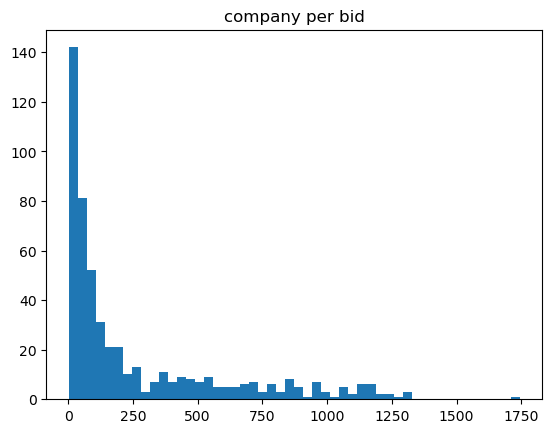

In [18]:
import os
import sys
import tabulate
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt

PATH = '/home/user/pengfei/toubiao/data/training/merged-training.csv'

df = pd.read_csv(PATH)
logging.info('data shape: {}'.format(df.shape))
for col in ('标段唯一标识', '投标人名称', '投标人代码'):
    logging.info('unique {}: {}'.format(col, df[col].nunique()))
biao_df = df.groupby(by='标段唯一标识')['投标人名称'].nunique()
display(biao_df.head())
plt.hist(biao_df, bins=50)
plt.title('company per bid')

df.columns.to_frame().reset_index()

In [22]:
import tabulate
pd.set_option('display.max_columns', 100)
print(tabulate.tabulate(df.head(), headers=df.columns, tablefmt='pretty'))
df.head()

+---+--------------+------------+-------------------------+------------------------------------------+----------------+-------------------+----------------------------+--------------------------+--------------+------------+--------------+----------+--------------------------------------+----------------+--------------------------+------------------------+--------------------------+------------------------------+-----------------+--------------------+----------------------------+-------------------------+------------------------------------------+--------------------------+------------------+------------+---------------+-------------------+------------+------------+------------+----------+----------+-----------------+-------------------+-------------------------+------------------------------------------+--------------------+----------------+--------------------------+----------------------------------+-------------------------------------------------------------------------------------

,Unnamed: 0.1,Unnamed: 0,标段编号,标段名称,标段创建时间,项目编号,项目编号_1,所属项目统一代码,所属项目类型,项目所在地,标段最高限价,数据来源,标段唯一标识,开标时间,招标单位统一社会信用代码,招标单位名称,招标代理统一社会信用代码,招标代理名称,Unnamed: 0_copy,投标人代码,投标人名称,标段编号_copy,标段名称_copy,投标人注册地行政区域代码,投标文件上传时间,投标金额,数据来源_copy,Unnamed: 0_copy.1,BiaoDuanNO,中标人代码,中标人名称,中标时间,中标金额,投标人名称_copy,Unnamed: 0_copy.2,标段编号_copy.1,标段名称_copy.1,投标人代码_copy,投标联系人电话,加密锁号,zaojiasuo1,制作码,MAC地址,下载招标文件IP,下载招标文件时间,投标文件上传IP,投标文件上传时间_copy,开标远程解密IP,所属项目类型_copy,项目所在行政区域,数据来源_copy.1
0,0,0,B3209250001000020002001,2023小区雨污分流及清淤养护工程（二标段）,2023/6/20 0:00,B3209250001000020,小区雨污分流及清淤养护工程,2302-320925-89-05-805283,住建,320925,10032600.0,盐城,001330d3-6f28-4c2d-bdc8-17f1f886d756,2023/6/20 9:00,913209257395801545,建湖县污水处理有限公司,91320925MA23FWC92Y,江苏森达工程项目管理有限公司,0,91320722MA202MXNXU,江苏等优建设工程有限公司,B3209250001000020002001,2023小区雨污分流及清淤养护工程（二标段）,320722.0,2023/6/19 23:07,9012047.20,盐城,NaN,NaN,NaN,NaN,NaN,NaN,NaN,269636,B3209250001000020002001,2023小区雨污分流及清淤养护工程（二标段）,91320722MA202MXNXU,18082033198,1267573014,b1ec9fbf2af5490a82f6fafa4f588005,802BF98D2BD1、8C1645E0BBC2@ST1000LM035-1RK172、S...,80-2B-F9-8D-2B-D1,2409:8a20:72be:e250:28a4:fd90:f5a8:7da9,NaN,2409:8a20:72be:e250:5c7f:419e:77f4:2d10,2023/6/19 23:05,NaN,住建,320925.0,盐城
1,1,0,B3209250001000020002001,2023小区雨污分流及清淤养护工程（二标段）,2023/6/20 0:00,B3209250001000020,小区雨污分流及清淤养护工程,2302-320925-89-05-805283,住建,320925,10032600.0,盐城,001330d3-6f28-4c2d-bdc8-17f1f886d756,2023/6/20 9:00,913209257395801545,建湖县污水处理有限公司,91320925MA23FWC92Y,江苏森达工程项目管理有限公司,1,91320922571389910J,盐城海成建筑劳务有限公司,B3209250001000020002001,2023小区雨污分流及清淤养护工程（二标段）,320922.0,2023/6/19 16:41,8947616.55,盐城,NaN,NaN,NaN,NaN,NaN,NaN,NaN,269665,B3209250001000020002001,2023小区雨污分流及清淤养护工程（二标段）,91320922571389910J,15380508080,77A600000039BE69C4874351,9702055E190A323C,0C9D92785D9C@KINGBANK KP330、WDC WD10EZEX-08WN4...,0C-9D-92-78-5D-9C,222.188.57.78,NaN,222.188.57.78,2023/6/19 16:38,NaN,住建,320925.0,盐城
2,2,0,B3209250001000020002001,2023小区雨污分流及清淤养护工程（二标段）,2023/6/20 0:00,B3209250001000020,小区雨污分流及清淤养护工程,2302-320925-89-05-805283,住建,320925,10032600.0,盐城,001330d3-6f28-4c2d-bdc8-17f1f886d756,2023/6/20 9:00,913209257395801545,建湖县污水处理有限公司,91320925MA23FWC92Y,江苏森达工程项目管理有限公司,2,91320891MA20MFQN50,江苏路梦建设工程有限公司,B3209250001000020002001,2023小区雨污分流及清淤养护工程（二标段）,320803.0,2023/6/19 17:38,9057869.16,盐城,NaN,NaN,NaN,NaN,NaN,NaN,NaN,269048,B3209250001000020002001,2023小区雨污分流及清淤养护工程（二标段）,91320891MA20MFQN50,13382318688,1410936671,9733c801000702079e12000b0012003d,7C10C9C0015E@WDC WD5000AAKX-003CA0、Founder SSD...,7C-10-C9-C0-01-5E,180.125.122.229,NaN,180.125.122.229,2023/6/19 17:34,NaN,住建,320925.0,盐城
3,3,0,B3209250001000020002001,2023小区雨污分流及清淤养护工程（二标段）,2023/6/20 0:00,B3209250001000020,小区雨污分流及清淤养护工程,2302-320925-89-05-805283,住建,320925,10032600.0,盐城,001330d3-6f28-4c2d-bdc8-17f1f886d756,2023/6/20 9:00,913209257395801545,建湖县污水处理有限公司,91320925MA23FWC92Y,江苏森达工程项目管理有限公司,3,91320600MA25T7723A,江苏华务市政有限公司,B3209250001000020002001,2023小区雨污分流及清淤养护工程（二标段）,320941.0,2023/6/19 16:30,9295487.30,盐城,NaN,NaN,NaN,NaN,NaN,NaN,NaN,269018,B3209250001000020002001,2023小区雨污分流及清淤养护工程（二标段）,91320600MA25T7723A,15051347920,1368699084,99985585b55848c8b8ad6b1bce501f98,18C04D20B1CA@WDC WDS500G2B0C-00PXH0@BFEBFBFF00...,18-C0-4D-20-B1-CA,240e:3a1:8912:35f0:6b:284f:e990:ea2d,NaN,240e:3a1:8912:35f0:6b:284f:e990:ea2d,2023/6/19 15:04,NaN,住建,320925.0,盐城
4,4,0,B3209250001000020002001,2023小区雨污分流及清淤养护工程（二标段）,2023/6/20 0:00,B3209250001000020,小区雨污分流及清淤养护工程,2302-320925-89-05-805283,住建,320925,10032600.0,盐城,001330d3-6f28-4c2d-bdc8-17f1f886d756,2023/6/20 9:00,913209257395801545,建湖县污水处理有限公司,91320925MA23FWC92Y,江苏森达工程项目管理有限公司,4,91320114MA1Y0J0R27,南京安途达市政工程有限公司,B3209250001000020002001,2023小区雨污分流及清淤养护工程（二标段）,320115.0,2023/6/19 22:10,9162643.66,盐城,NaN,NaN,NaN,NaN,NaN,NaN,NaN,269268,B3209250001000020002001,2023小区雨污分流及清淤养护工程（二标段）,91320114MA1Y0J0R27,025-85789166,1331257736,9733c80100070206b90a000100290031,803253680380@SAMSUNG MZVLB512HAJQ-00000@BFEBFB...,80-32-53-68-03-80,223.67.185.251,NaN,2409:8a20:8a17:2040:2032:3ffd:210d:495e,2023/6/19 22:05,NaN,住建,320925.0,盐城


Text(0.5, 1.0, 'company * bid per month')

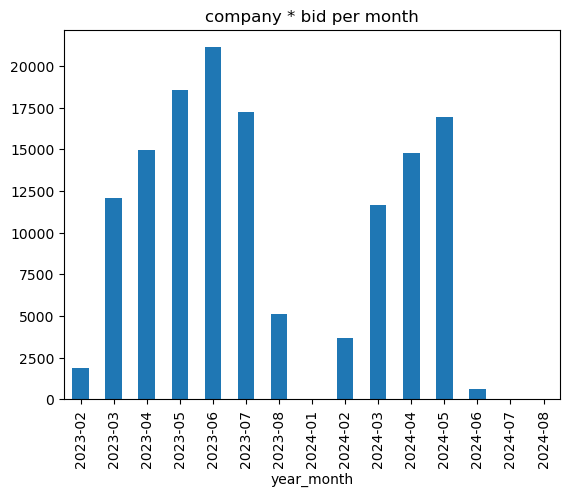

In [24]:
# bid month
# Step 1: Convert to datetime
df['datetime'] = pd.to_datetime(df['开标时间'], format='%Y/%m/%d %H:%M')

# Step 2: Extract year-month
df['year_month'] = df['datetime'].dt.to_period('M')  # or use dt.strftime('%Y-%m') for string

# Step 3: Count per month
counts = df['year_month'].value_counts().sort_index()

# Step 4: Plot
counts.plot(kind='bar')
plt.title('company * bid per month')

Text(0.5, 1.0, 'bid per month')

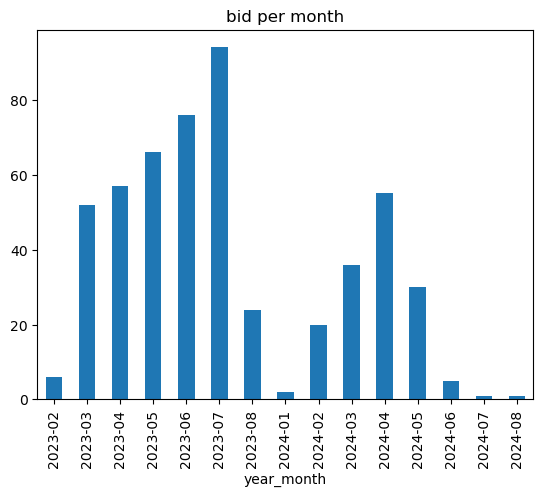

In [29]:
# bid month
# Step 1: Convert to datetime
df['datetime'] = pd.to_datetime(df['开标时间'], format='%Y/%m/%d %H:%M')

# Step 2: Extract year-month
df['year_month'] = df['datetime'].dt.to_period('M')  # or use dt.strftime('%Y-%m') for string

month_df = df.groupby(by = 'year_month')['标段唯一标识'].nunique()
#.reset_index()
#display(month_df.head())

# Step 3: Count per month
#counts = month_df['year_month'].value_counts().sort_index()
counts = month_df.sort_index()

# Step 4: Plot
counts.plot(kind='bar')
plt.title('bid per month')

# K-prototype

In [34]:
os.system("pip install kmodes")

Looking in indexes: https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple


0

In [36]:
import numpy as np
from kmodes.kmodes import KModes

# random categorical data
# can only handle categorical data
data = np.random.choice(20, (100, 10))

km = KModes(n_clusters=4, init='Huang', n_init=5, verbose=1)

clusters = km.fit_predict(data)

# Print the cluster centroids
print('cluster:', km.cluster_centroids_)

data: [[ 6  8  3  5  2  3 12 12 13  8]
 [12  5 16 14 14  8  3 12  1 19]
 [13 18 10 18  9 10  3  5  9  4]
 [13  2  8 18 18 12 11  3  5 15]
 [ 8 19 11 15  5 15  4  6 13 16]
 [16  8  6 16  5 15  5  2  7 18]
 [ 6  8  7  0 15 12  8 18  9 19]
 [ 0  2 10 15  4 14 17  8 16  0]
 [16 11 15 13 12 14  9  0 10  0]
 [ 2 16  4  1 12 15 14 12  9  0]
 [16 12  8 18 15 10 13 13  5 14]
 [17 14  3  4  6  5 14 19 15 17]
 [17  0 10 11  8 13 16 16  1 16]
 [ 9 14 19  8  2 14  0 10 16 14]
 [16  7  4  8 10  0  2  1  8 12]
 [ 3  5 16  8  1 18 16 11 16 13]
 [11  9 14 13  3  3  1 17 14 17]
 [15 11  2 11  5  9 18 16 19  2]
 [ 3 12  1  4  4  7 11 17  7  9]
 [18 17 17  4  0  3  5  6 13  3]
 [16 17 15 13  8 11  9  9 12  6]
 [11  5 12  6  1  7 13 12 15  0]
 [13  0  1  5 18  2 17  5  3 17]
 [18  5  8 18 11 17 16  3 12  7]
 [18 18 12 16  0  1  5 17 12 11]
 [ 5 13  3 15  0  7 12 10  0 10]
 [16 16  5 16  1 17 17 13  2  5]
 [18  7 11 15  4 10  1 10 17 17]
 [17  6  3 18 14 14 15 10  2  3]
 [14  0  9  7  9 19  1 13  9  6]
 [16

In [44]:
feature_names = [
    "标段名称",
    "标段创建时间",
    "项目编号",
    "项目编号_1",
    "所属项目统一代码",
    "所属项目类型",
    "项目所在地",
    "标段最高限价",
    "数据来源",
    "标段唯一标识",
    "开标时间",
    "招标单位统一社会信用代码",
    "招标单位名称",
    "招标代理统一社会信用代码",
    "招标代理名称",
    "投标人代码",
    "投标人名称"]
training_df = df[feature_names].copy()
for col in training_df.columns:
    training_df[col] = training_df[col].astype('category').cat.codes

#training_df.astype(str)
logging.info('training shape: {}'.format(training_df.shape))

km = KModes(n_clusters=20, init='Huang', n_init=5, verbose=1)

clusters = km.fit_predict(training_df)

# Print the cluster centroids
print('cluster:', km.cluster_centroids_)

INFO:root:training shape: (138616, 17)


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 26502, cost: 1450208.0
Run 1, iteration: 2/100, moves: 1801, cost: 1450156.0
Run 1, iteration: 3/100, moves: 17, cost: 1450156.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...


KeyboardInterrupt: 

# Clustering

[scikit-learn](https://scikit-learn.org/stable/modules/clustering.html)